In [1]:
# #載入GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

1594715642.npz	1594716050.npz	sample_data


## 引入函示庫

In [2]:
import cv2
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import regularizers
from imgaug import augmenters as iaa
import random


print('函示庫匯入成功..')

Using TensorFlow backend.


函示庫匯入成功..


In [ ]:
keras.__version__

'2.3.1'

##載入訓練資料

In [3]:
print('載入訓練資料...')
e0 = cv2.getTickCount() #設置訓練資料所用時間起始點

# 載入訓練資料
image_array = np.zeros((1,120, 320,1))
label_array = np.zeros((1, 3), 'float')
training_data = glob.glob('./drive/My Drive/AIOT06_Maker種子/Assets/江盈慧/*.npz') # 路徑請依照訓練資料放置的地方 #drive/My Drive/AIOT/TrainingDataSet/Angela/*.npz
# training_data = glob.glob('./*.npz') 
print("載入完成")

載入訓練資料...
載入完成


In [4]:
# if no data, exit

if not training_data:
    print("此路徑沒有訓練資料，程式關閉..")
    sys.exit()

for single_npz in training_data:
    with np.load(single_npz) as data:
        train_temp = data['train']
        train_labels_temp = data['train_labels']
    image_array = np.vstack((image_array, train_temp))
    label_array = np.vstack((label_array, train_labels_temp))
# print(image_array.shape)
# print(label_array.shape)
#將 所有的.npz檔內的資料 分成 X訓練資料 及 y訓練label
X = (image_array[1:,:]).astype('uint8') #轉成 uint8是為了可以用資料增強中的亮度調整Funtion
y = label_array[1:,:]

print('training_data',training_data)
print('Image array shape: ', X.shape)
print('Label array shape: ', y.shape)

e00 = cv2.getTickCount() #設置訓練資料所用時間結束點
time0 = (e00 - e0)/ cv2.getTickFrequency() #訓練資料所用時間
print(f'載入訓練資料所用時間: {time0:.2f}秒')

training_data ['./drive/My Drive/AIOT06_Maker種子/Assets/江盈慧/1594879144.npz', './drive/My Drive/AIOT06_Maker種子/Assets/江盈慧/1594879890.npz']
Image array shape:  (685, 120, 320, 1)
Label array shape:  (685, 3)
載入訓練資料所用時間: 11.03秒


## 資料增強

In [ ]:
# !pip3 install imgaug    #可以用來資料增強的函示庫 https://imgaug.readthedocs.io/en/latest/

In [5]:
# 資料增強
def zoom(image): #縮放增強功能(zoom augmentation function)
  zoom = iaa.Affine(scale=(1,1.3)) #表示可以將圖片放大到30% ，scale=(縮放範圍) 
  image = zoom.augment_image(image) # 利用此方法augment_image，將上面zoom參數，應用到image
  return image



In [6]:
#Image Padding 水平及垂直位移
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y':(-0.1, 0.1)})  # x水平位移:(右%，左%) , y垂直位移:(上%，下%)
  image = pan.augment_image(image)
  return image

In [7]:
#亮度隨機變化(隨機變黑或變亮) altering brightness
def image_random_brightness(image):
  brigtness = iaa.Multiply((0.2, 1.2)) #將圖片乘以特定值(該值大於1，變亮，反之) (Multiply all the "pixel intensities" inside the image thus any pixel instensity mulitiplide by a value less than 1 will become darker)
  image = brigtness.augment_image(image)    #課程說 以他的經驗 圖片較暗 效果會比較好 所以設定 乘以 0.2 ~1.2 之間的隨機數
  return image

In [8]:
# 翻轉 fliping
def img_random_flip(image, label):
  image = cv2.flip(image,1) # 參數1:翻轉對象， 參數2:0為垂直翻轉, 1為水平, -1代表水平和垂直的組合
  # label_flip = label
  # label_flip[1], label_flip[2] = label[2] ,label[1]
  label_flip = [label[0], label[2], label[1]]
  label_flip = np.asarray(label_flip)
  # if label_flip[0] != 1 :       #如果是 [0,1,0] 就變成 [0,0,1] 反之~
  #     if label_flip[1] == 1:
  #        label_flip[1] = 0.
  #        label_flip[2] = 1.
  #     else: 
  #        label_flip[1] = 1.
  #        label_flip[2] = 0.
    
  return image , label_flip

翻轉前Label [0. 0. 1.]
翻轉後Label [0. 1. 0.]


Text(0.5, 1.0, 'Zoom_image')

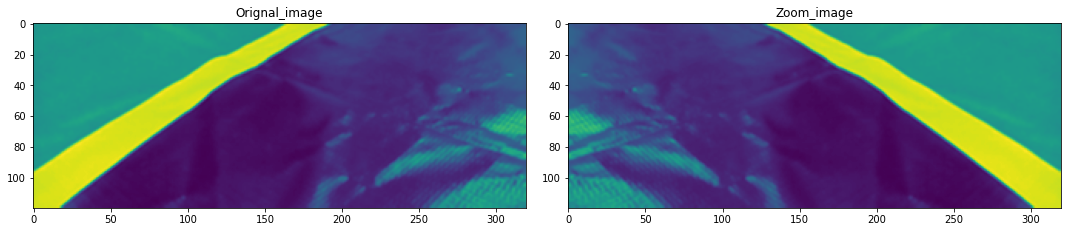

In [9]:
#可視化 
random_index = random.randint(0, len(X) - 1)

image = X[random_index] 
label = y[random_index]

orignal_image =image.reshape(120,320) #reshape成圖片格式

zoom_image, label_flip = img_random_flip(image,label)  #翻轉

print("翻轉前Label",label)
print('翻轉後Label' ,label_flip)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(orignal_image)
axs[0].set_title('Orignal_image')
axs[1].imshow(zoom_image)
axs[1].set_title('Zoom_image')

In [10]:
def random_augment(image, label): #將圖片 隨機產生上述4種資料增強結果
    if np.random.rand() < 0.5: #隨機產生一個0~1之間的浮點數。 (表示有50%的機率此條件為True)
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = image_random_brightness(image)
    if np.random.rand() < 0.5:
        image,label= img_random_flip(image,label)  
    return image, label

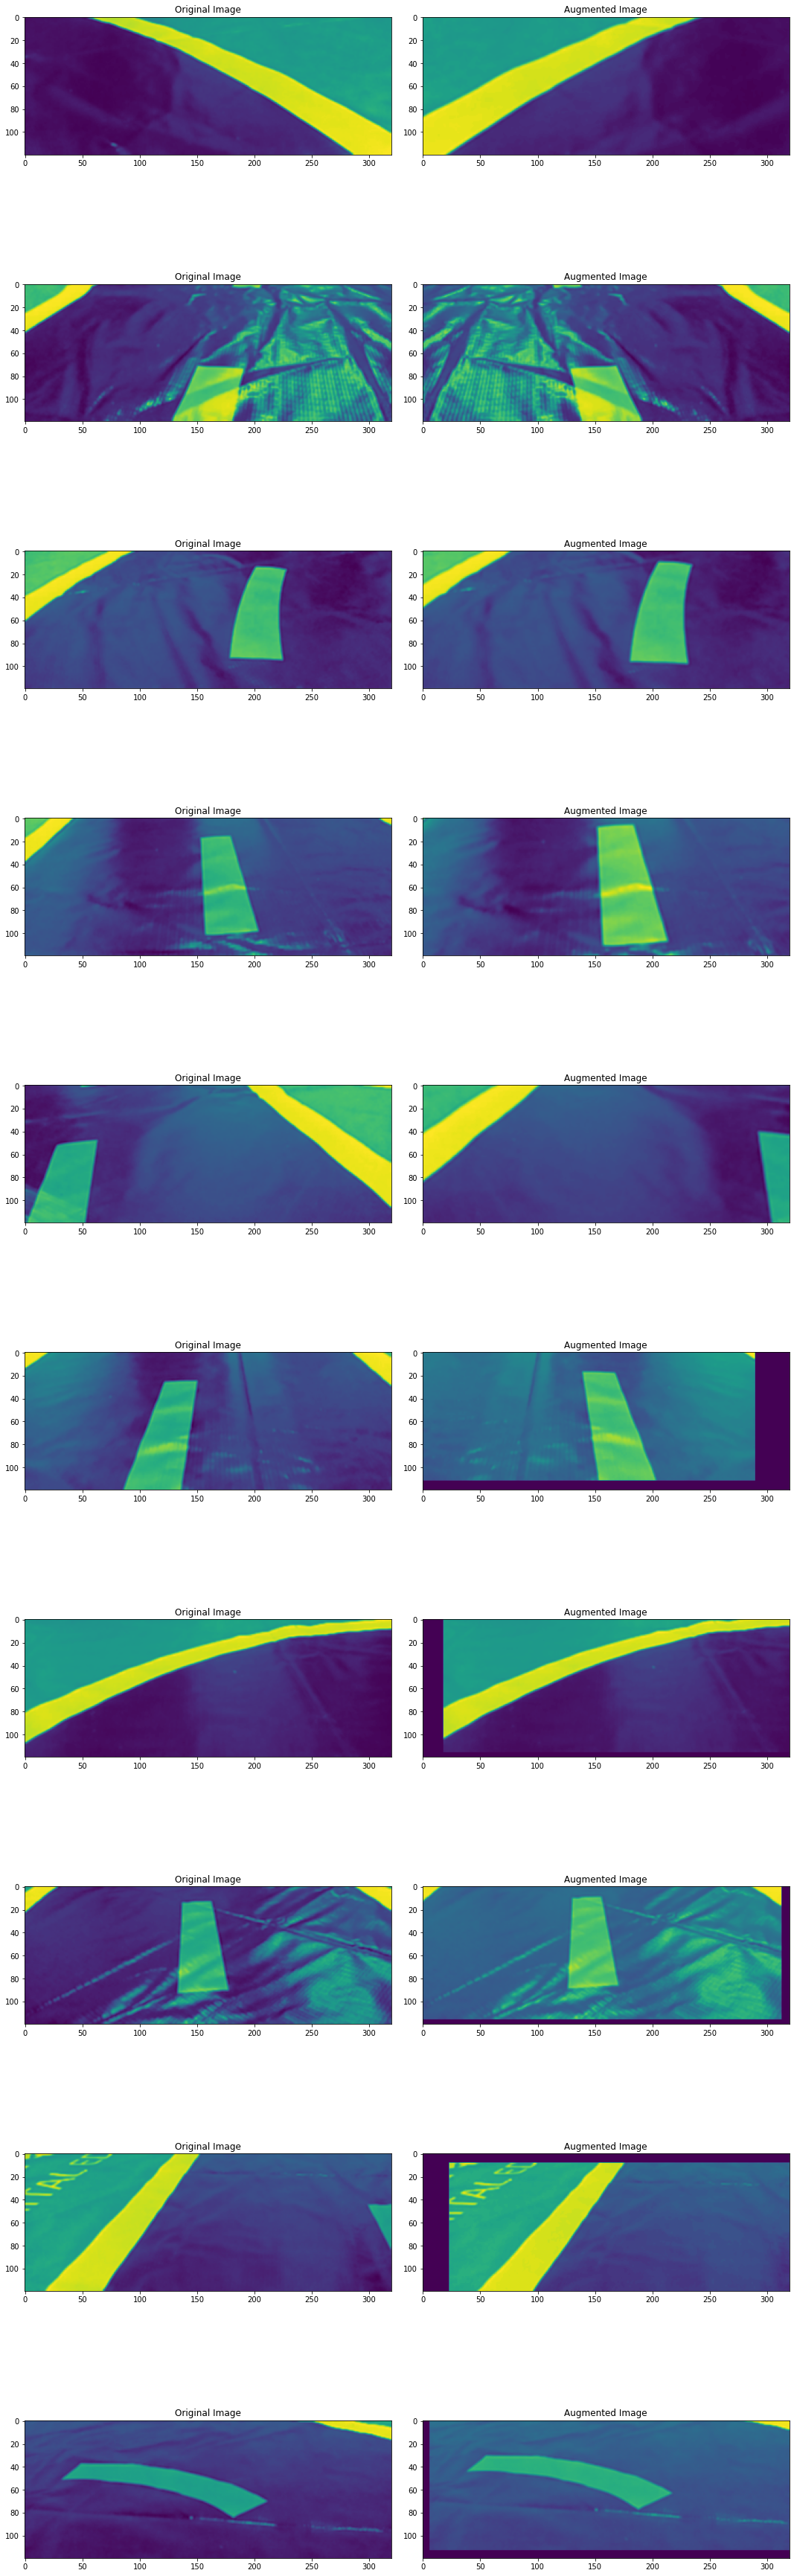

In [11]:
#可視化 資料增強
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(X) - 1)
  random_image = X[randnum]
  random_label = y[randnum]
    
  original_image = random_image.reshape(120,320) 


  augmented_image, random_label = random_augment(random_image, random_label)
  # print(f'Label_fliped:{random_label}')
  axs[i][0].imshow(original_image )
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image.reshape(120,320) )
  axs[i][1].set_title("Augmented Image")

## 模型預處理

In [12]:
# # 建立圖形預處理的函式
# def img_preprocess(img):
#     img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # 灰階
#     img = cv2.GaussianBlur(img, (3,3),0)#高斯模糊使圖像更平滑，減少噪點
#     img = img/255 #歸一化 標準化 Normalization 
#     # img =img.reshape(1,120,320,1)
#     return img

In [13]:
# image = X[3]
# original_image = image
# preprocessed_image = img_preprocess(image)
# fig, axs = plt.subplots(1,2,figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image.reshape())
# axs[0].set_title('original_image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('preprocessed_image')

## 訓練及驗證資料生成器 (Batch Generator)

In [14]:
#將X訓練資料 , y訓練資料label，拆分成 訓練資料、測試資料、訓練資料label、測試資料label。比例為:訓練80%，測試20%
train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.2,random_state=6) 
print("資料拆分完成..")

資料拆分完成..


In [15]:
assert(train.shape[0] == train_labels.shape[0] ),"圖片數量要與Label數量一致"

In [16]:
def batch_generator(imgs, lab, batch_size, istraining):

  while True:
    batch_img = []
    batch_labels = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(imgs)-1)

      if istraining : #訓練資料(要資料增強)
      
        im, labels = random_augment(imgs[random_index], lab[random_index])
        #im, labels = imgs[random_index], lab[random_index]
      else:  #驗證資料(不要資料增強)
        im = imgs[random_index]
        labels = lab[random_index]
      # im = img_preprocess(im)  #圖片預處理
      im = im/255 # Normalization    
      im = im.reshape(120,320,1)  #轉4D (預處理過便灰階 所以channel = 1)
      batch_img.append(im)    #這時候append到[]才是真正4D
      batch_labels.append(labels)
    
    yield (np.asarray(batch_img), np.asarray(batch_labels))

In [17]:

x_train_gen,y_train_gen = next(batch_generator(train, train_labels, 1,1)) #測試資料，參數4為1 = 要做資料增強
x_valid_gen,y_valid_gen = next(batch_generator(test, test_labels, 2,0)) #驗證資料，參數4為0 = 不做資料增強

(1, 120, 320, 1)
(1, 120, 320, 1)
確認一下此Label有沒有跟測試圖片一致 =>  [[1. 0. 0.]]


Text(0.5, 1.0, 'Validation Image')

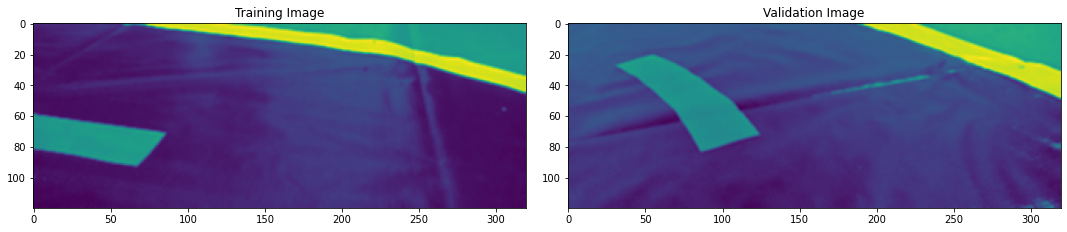

In [18]:
#可視化  測試batch_generator的結果，測試1個batch_size
x_train_gen,y_train_gen = next(batch_generator(train, train_labels, 1,1)) #測試資料，參數4為1 = 要做資料增強
x_valid_gen,y_valid_gen = next(batch_generator(test, test_labels, 1,0)) #驗證資料，參數4為0 = 不做資料增強
print(x_train_gen.shape)
print(x_valid_gen.shape)

print('確認一下此Label有沒有跟測試圖片一致 => ', y_train_gen)
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0].reshape((120,320)))  #這裡reshape的原因 因為 batch_generator 出來的shape 是4D,imshow 只能輸入 (120,320)
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0].reshape((120,320)))
axs[1].set_title('Validation Image')

## 模型架構及訓練

In [19]:
#-------------------------------模型訓練---------------------------------------------------------------------------------------------------------
e1 = cv2.getTickCount() #設置模型訓練所用時間起始點
num_classes = 3 #class = 前 [1,0,0] 、左 [0,1,0] 、 右[0,0,1]  3種
# 建立lenet_model(CNN):
model = Sequential()
model.add(Conv2D(30,(5,5),input_shape=(120,320,1),activation='relu')) #Convolution層 擷取圖片特徵 (輸出為特徵圖片(feature map) 數量等於濾波器數量)。
model.add(Conv2D(30,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) #MaxPool層 減少特徵圖片尺寸，並保留特徵。
model.add(Dropout(0.5))

model.add(Conv2D(15,(3,3),activation='relu'))
model.add(Conv2D(15,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5)) #DropOut層 訓練時隨機丟到50%(0.5)的神經元，讓模型可以學習到不同面向的東西，降低過度擬合情況(OverFitting)


model.add(Flatten()) #將圖片攤成一維向量，因為要餵入DNN神經網路
model.add(Dense(500,activation='relu')) #神經網路層，這裡設定500顆神經元(node)
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax')) #最後輸出為3個類別(Calss = 前，左，右)，激活函數使用Softmax將結果轉成機率分布。
#編輯模型
model.compile(Adam(learning_rate=0.0005),loss ='categorical_crossentropy',metrics=['accuracy'])

print(f'模型計算圖: ')
print(model.summary()) #印出計算圖
print('訓練開始...')
# history = model.fit(x=train/255,y=train_labels,epochs=30,validation_data=(test/255,test_labels),batch_size=100,verbose=1,shuffle=1)
history = model.fit_generator(batch_generator(train, train_labels,batch_size= 80,istraining= 1),  #呼叫batch_generator 來生成批次 訓練資料(資料增強、圖片預處理過)及Label
                              steps_per_epoch=15 , 
                              epochs= 30, 
                              validation_data= batch_generator(test, test_labels, batch_size=80, istraining=0), #呼叫batch_generator 來生成批次 驗證資料(圖片預處理過)及Label
                              validation_steps= 15,
                              verbose= 1, 
                              shuffle= 1)
#-------------------------------模型訓練結束------------------------------------------------------------------------------------------------------

e2 = cv2.getTickCount()  #設置模型訓練所用時間結束時點

time = (e2 - e1)/cv2.getTickFrequency() #訓練所用時間(分鐘)
print(f'訓練時間:{time/60:.2f}分')

模型計算圖: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 316, 30)      780       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 114, 314, 30)      8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 57, 157, 30)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 57, 157, 30)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 155, 15)       4065      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 53, 153, 15)       2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 76, 15

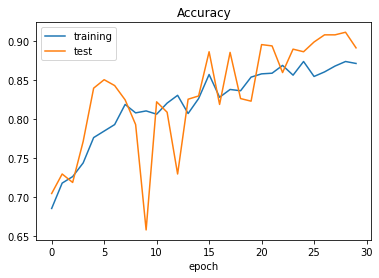

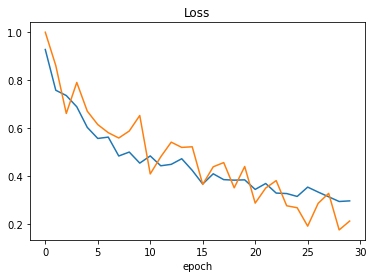

In [21]:
#準度曲線
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#損失(Loss)曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# with open("model.json", "w") as file:
#     file.write(model.to_json())
# model.save_weights("weights.h5")

In [22]:
# save model
model.save('model.h5') # 存儲模型
print('模型已存檔..')

模型已存檔..


In [23]:
from google.colab import files 
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>